In [ ]:
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
data = scipy.io.loadmat("/content/drive/MyDrive/dissertation/LearningData.mat")

In [ ]:
r = data['rmat_post'][0]
print(r.shape)
print(r[0].shape,r[1].shape,r[2].shape)

(3,)
(135, 138, 57) (120, 138, 57) (254, 138, 57)


In [ ]:
#create new dataset by combining all experiments for each animal
def create_dataset(exp):
  vertical = exp[0]
  new_v = np.take(vertical, list(range(8,25)), axis = 2) #taking values from -1 to 1 sec using tsamples array
  angled = exp[1]
  new_a = np.take(angled, list(range(8,25)), axis = 2) #taking values from -1 to 1 sec using tsamples array
  gray_corridor = exp[2]
  new_g = np.take(gray_corridor, list(range(8,25)), axis = 2) #taking values from -1 to 1 sec using tsamples array
  #creating y labels 0-vertical, 1-angled, 2-gray corridor
  y = [0 for i in range(new_v.shape[0])] + [1 for i in range(new_a.shape[0])] + [2 for i in range(new_g.shape[0])]
  combine = np.concatenate((new_v,new_a,new_g))
  #changing axis as required by lstm (samples, time, features)
  changed_axis = np.transpose(combine,axes = [0,2,1])
  return changed_axis,np.array(y)

In [ ]:
#finding nan values in X and dropping them
def remove_empty(X,y):
  print("total no of empty values in X = ",np.isnan(X).sum())
  print("old shape = ", X.shape, y.shape)
  trials_with_nan = []
  for ind,i in enumerate(X):
    if np.isnan(i).sum()!=0:
      print("trail = ", ind, " empty values = ", np.isnan(i).sum())
      trials_with_nan.append(ind)
  X = np.delete(X, trials_with_nan, axis = 0) #dropping the trials with empty values from the dataset
  y = np.delete(y, trials_with_nan)
  print("new X shape = ", X.shape,y.shape)
  return X,y

In [ ]:
#normalizing by finding max and minimum for all neurons in later part can try based on cell type
def normalize(X,y):
  xmax,xmin = np.max(X.flatten()),np.min(X.flatten())
  print(xmax,xmin)
  fun = lambda t: (t-xmin)/(xmax-xmin)
  xfun = np.vectorize(fun)
  x = xfun(X)
  return x,y

In [ ]:
X,y = create_dataset(r)

In [ ]:
print(X.shape,y.shape)

(509, 17, 138) (509,)


In [ ]:
X,y = remove_empty(X,y)
print(np.isnan(X).sum())

total no of empty values in X =  0
old shape =  (509, 17, 138) (509,)
new X shape =  (509, 17, 138) (509,)
0


In [ ]:
#normalizing values between 0 and 1
X,y = normalize(X,y)

4.8167887 -0.1685003


In [ ]:
print(X.shape,y.shape)

(509, 17, 138) (509,)


In [ ]:
np.save("/content/drive/MyDrive/dissertation/rat1_post_X",X)
np.save("/content/drive/MyDrive/dissertation/rat1_post_y",y)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1, random_state = 8)
X_trn,X_val,y_trn,y_val = train_test_split(X_train,y_train,test_size = 0.1, random_state = 8)
print(X_trn.shape,X_val.shape,X_test.shape)

(412, 17, 138) (46, 17, 138) (51, 17, 138)


## Using keras tuner for hyperparameter tuning

In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
import keras_tuner
def call_model(units, units1, activation, lr):
    inp_shape = (17,138) #17 timestamps and 138 features
    model = keras.Sequential()
    model.add(LSTM(units = units,input_shape = inp_shape)) #try using return_sequences = True if possible.
    model.add(layers.Dense(units=units1, activation=activation))
    model.add(layers.Dense(3, activation="softmax"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_model(hp):
    units = hp.Int("units", min_value=10, max_value=25, step=2)
    units1 = hp.Int("units1",min_value = 5,max_value = 15, step = 1)
    activation = hp.Choice("activation", ["relu", "tanh","sigmoid"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_model(units=units, units1 = units1, activation=activation, lr=lr)
    return model


build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory="/content/drive/MyDrive/dissertation_results",
    project_name="rat1_post",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 25, 'step': 2, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 15, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(X_trn, y_trn, epochs=50, validation_data=(X_val, y_val))

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.97826087474823

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 05m 52s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(17, 138))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14)                8568      
                                                                 
 dense (Dense)               (None, 15)                225       
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
Total params: 8,841
Trainable params: 8,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/dissertation_results/rat1_post
Showing 10 best trials
Trial summary
Hyperparameters:
units: 14
units1: 15
activation: tanh
lr: 0.004097698822304509
Score: 1.0
Trial summary
Hyperparameters:
units: 20
units1: 8
activation: sigmoid
lr: 0.005596263010459105
Score: 1.0
Trial summary
Hyperparameters:
units: 22
units1: 13
activation: relu
lr: 0.004806061600503526
Score: 1.0
Trial summary
Hyperparameters:
units: 14
units1: 8
activation: tanh
lr: 0.003124363394528359
Score: 1.0
Trial summary
Hyperparameters:
units: 12
units1: 11
activation: sigmoid
lr: 0.0056309665086507685
Score: 1.0
Trial summary
Hyperparameters:
units: 12
units1: 8
activation: sigmoid
lr: 0.0068764992685704076
Score: 1.0
Trial summary
Hyperparameters:
units: 20
units1: 8
activation: sigmoid
lr: 0.0021111648883517264
Score: 1.0
Trial summary
Hyperparameters:
units: 10
units1: 14
activation: relu
lr: 0.001411348024061337
Score: 1.0
Trial summary
Hyperparameters:
units: 22
unit

In [ ]:
l = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate = 0.004097698822304509)
best_model.compile(loss= l, optimizer = opt,metrics=['accuracy'])
history = best_model.fit(X_trn,y_trn,batch_size = 32,epochs = 50,verbose = 2,steps_per_epoch = X_trn.shape[0]/50,validation_data=(X_val,y_val))

#lstm_1

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras import layers,models

In [ ]:
def create_model(units,units1,activation):
  input_shape = (17,138) #17 timestamps and 138 features
  basic_lstm = Sequential()
  basic_lstm.add(LSTM(units=units,input_shape = input_shape))
  basic_lstm.add(Dense(units = units1,activation = activation))
  basic_lstm.add(Dense(3,activation = 'softmax'))
  return basic_lstm

In [ ]:
lstm_1 = create_model(units = 14,units1 = 15,activation='tanh')
lstm_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 14)                8568      
                                                                 
 dense_2 (Dense)             (None, 15)                225       
                                                                 
 dense_3 (Dense)             (None, 3)                 48        
                                                                 
Total params: 8,841
Trainable params: 8,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=5)
l = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate= 0.0040977)
lstm_1.compile(loss= l, optimizer = opt,metrics=['accuracy'])
history = lstm_1.fit(X_trn,y_trn,batch_size = 32,epochs = 50,verbose = 2,steps_per_epoch = X_trn.shape[0]/50,validation_data=(X_val,y_val))

Epoch 1/50
8/8 - 2s - loss: 1.0058 - accuracy: 0.5139 - val_loss: 0.9318 - val_accuracy: 0.5870 - 2s/epoch - 285ms/step
Epoch 2/50
8/8 - 0s - loss: 0.9057 - accuracy: 0.6585 - val_loss: 0.7422 - val_accuracy: 0.8043 - 86ms/epoch - 10ms/step
Epoch 3/50
8/8 - 0s - loss: 0.7636 - accuracy: 0.6796 - val_loss: 0.5480 - val_accuracy: 0.7609 - 91ms/epoch - 11ms/step
Epoch 4/50
8/8 - 0s - loss: 0.4515 - accuracy: 0.8438 - val_loss: 0.4225 - val_accuracy: 0.8043 - 90ms/epoch - 11ms/step
Epoch 5/50
8/8 - 0s - loss: 0.3636 - accuracy: 0.8732 - val_loss: 0.2324 - val_accuracy: 0.9130 - 95ms/epoch - 12ms/step
Epoch 6/50
8/8 - 0s - loss: 0.2298 - accuracy: 0.9225 - val_loss: 0.2282 - val_accuracy: 0.9130 - 91ms/epoch - 11ms/step
Epoch 7/50
8/8 - 0s - loss: 0.2310 - accuracy: 0.9236 - val_loss: 0.1773 - val_accuracy: 0.9348 - 95ms/epoch - 11ms/step
Epoch 8/50
8/8 - 0s - loss: 0.1571 - accuracy: 0.9577 - val_loss: 0.0941 - val_accuracy: 1.0000 - 93ms/epoch - 11ms/step
Epoch 9/50
8/8 - 0s - loss: 0.144

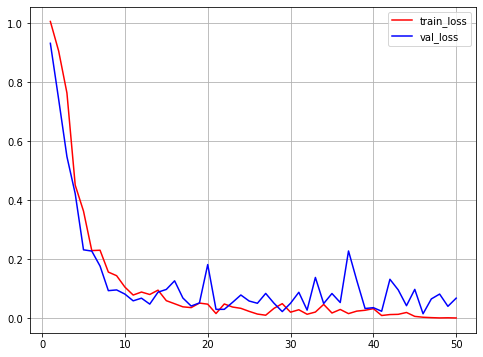

In [ ]:
m = history.history
plt.rcParams["figure.figsize"] = (8,6)
epochs = list(range(1,51))
plt.plot(epochs,m['loss'],'r',label = 'train_loss')
plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

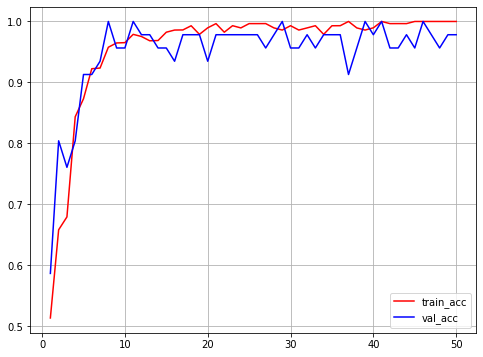

In [ ]:
plt.plot(epochs,m['accuracy'],'r',label = 'train_acc')
plt.plot(epochs,m['val_accuracy'],'b',label = 'val_acc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = lstm_1.predict(X_test,batch_size = 1)
ypred = np.argmax(y_pred,axis=1)
accuracy_score(y_test,ypred)

0.9803921568627451

In [ ]:
lstm_1.save("/content/drive/MyDrive/dissertation/time_series_classification/rat1_post/lstm_1.h5")